# Simulated Maximum Likelihood with PFJAX

**Mohan Wu, Pranav Subramani, Martin Lysy -- University of Waterloo**

**September 13, 2022**

## Summary

In the [Introduction](pfjax.ipynb) to **PFJAX**, we saw how to set up a model class for a state-space model and how to use a particle filter to estimate its marginal loglikelihood $\ell(\tth) = \log p(\yy_{0:T} \mid \tth)$.  In this tutorial, we'll use **PFJAX** to approximate the maximum likelihood estimator $\hat \tth = \argmax_{\tth} \ell(\tth)$ and its variance $\var(\hat \tth)$.

Once again we'll be working with the Brownian motion with drift model defined in the [Introduction](pfjax.ipynb):

$$
\begin{aligned}
x_0 & \sim \N(0, \sigma^2 \dt) \\
x_t & \sim \N(x_{t-1} + \mu \dt, \sigma^2 \dt) \\
y_t & \sim \N(x_t, \tau^2),
\end{aligned}
$$

where the model parameters are $\tth = (\mu, \sigma, \tau)$.  The details of setting up the appropriate model class are provided in the [Introduction](pfjax.ipynb).  Here we'll use the version of this model provided with **PFJAX**: `pfjax.models.BMModel`.

In [1]:
# jax
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random
from functools import partial
# plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import projplot as pjp
# pfjax
import pfjax as pf
from pfjax.models import BMModel
# stochastic optimization
import optax

## Simulate Data

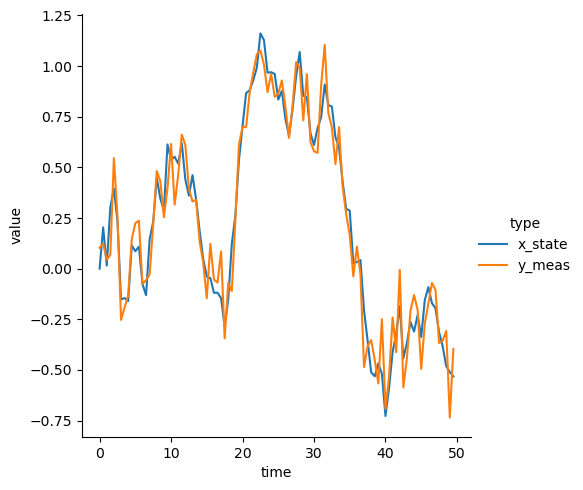

In [2]:
# parameter values
mu = 0.
sigma = .2
tau = .1
theta_true = jnp.array([mu, sigma, tau])

# data specification
dt = .5
n_obs = 100
x_init = jnp.array(0.)

# initial key for random numbers
key = jax.random.PRNGKey(0)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = jax.random.split(key)
y_meas, x_state = pf.simulate(
    model=bm_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true
)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)

## Stochastic Optimization

The first step to performing simulated maximum likelihood estimation with **PFJAX** is to estimate the MLE $\hat \tth = \argmax_{\tth} \ell(\tth)$.  To do this, we perform stochastic optimization of the particle filter objective function $\hat{\ell}(\tth)$, for which we'll need to approximate the score function $\nabla \ell(\tth) = \frac{\partial}{\partial \tth} \ell(\tth)$.

A straightforward approximation would be to use **JAX** to directly differentiate the particle filter approximation $\hat{\ell}(\tth)$.  However, this turns out to be biased \cite{corenflos_etal21}, in that in general $E[\frac{\partial}{\partial \tth} \hat{\ell}(\tth)] \neq \frac{\partial}{\partial \tth} \ell(\tth)$.  The [Gradient Comparisons](gradient_comparisons.ipynb) notebook compares the speed and accuracy of several stochastic approximations to the score function.  The recommended algorithm \cite{poyiadjis_etal11} is implemented in `pfjax.particle_filter_rb()`.  Note that this algorithm scales quadratically in the number of particles, whereas scaling is only linear with the basic particle filter `pfjax.particle_filter()`.  However, the quadratic algorithm requires far fewer particles for comparable (but superior) accuracy and speed.


We'll use the **Optax** package for gradient-based stochastic optimization in the code below.  First we write a simple wrapper function to stochastically maximize **PFJAX** state-space models.

In [35]:
def pf_stochopt(model, key, theta, y_meas, n_particles,
                learning_rate, n_steps):
    """
    Stochastic optimization using Adam.

    Args:
        model: A particle filter model object.
        key: PRNG key.
        theta: Initial parameter value.
        y_meas: JAX array with leading dimension `n_obs` containing the measurement variables 
                `y_meas = (y_0, ..., y_T)`, where `T = n_obs-1`.        
        n_particles: The number of particles to use in the particle filter.
        learning_rate: Optimizer learning rate.
        n_steps: Number of optimizer steps.

    Returns:
        theta: Parameter value at last step.
        loglik: JAX array of length `n_steps` containing a stochastic estimate of the loglikelihood at each step.
    """
    # set up and initialize the optimizer
    optimizer = optax.adam(learning_rate=learning_rate)
    opt_state = optimizer.init(params=theta)

    # optimizer step function
    @jax.jit
    def step(theta, key, opt_state):
        pf_out = pf.particle_filter_rb(
            model=model,
            key=key,
            y_meas=y_meas,
            n_particles=n_particles,
            theta=theta,
            history=False,
            score=True,
            fisher=False
        )
        opt_updates, opt_state = optimizer.update(
            updates=-1.0 * pf_out["score"], # optax assumes a minimization problem
            state=opt_state, 
            params=theta
        )
        theta = optax.apply_updates(params=theta, updates=opt_updates)
        return theta, opt_state, pf_out["loglik"]

    # optimizer loop
    subkeys = jax.random.split(key, n_steps)
    loglik_out = jnp.zeros((n_steps,))
    for i in jnp.arange(n_steps):
        theta, opt_state, loglik = step(theta=theta, key=subkeys[i], opt_state=opt_state)
        loglik_out = loglik_out.at[i].set(loglik)
        
    return theta, loglik_out

Next, we perform stochastic optimization for the Brownian motion model and the simulated data.

{'theta_opt': DeviceArray([-0.01,  0.19,  0.13], dtype=float64),
 'theta_true': DeviceArray([0. , 0.2, 0.1], dtype=float64)}

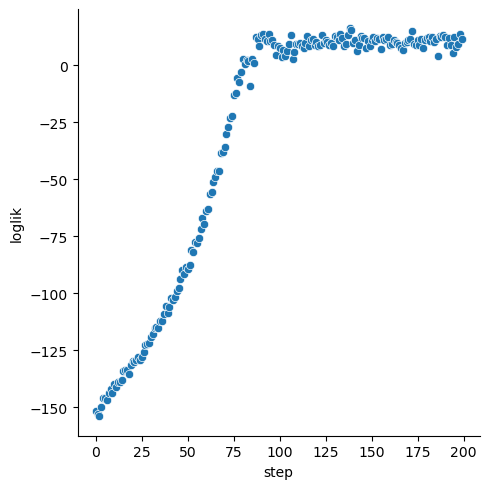

In [36]:
# optimization setup
theta_init = jnp.array([1., 1., 1.])
n_particles = 50
learning_rate = 0.01
n_steps = 200

theta_opt, loglik = pf_stochopt(
    model=bm_model,
    key=key,
    theta=theta_init,
    y_meas=y_meas,
    n_particles=n_particles,
    learning_rate=learning_rate,
    n_steps=n_steps
)

# plot loglikelihood as a function of step count
sns.relplot(
    data = {"step": jnp.arange(n_steps), "loglik": loglik},
    x = "step",
    y = "loglik"
)

# estimated and true parameter values
{"theta_opt": jnp.round(theta_opt, decimals=2), "theta_true": theta_true}

We see that the stochastic optimization converged after about 100 steps and that the estimate $\hat \tth$ is very close to the true parameter value.

## Variance Estimation

Suppose we had the MLE of the exact marginal likelihood, $\tilde{\tth} = \argmax_{\tth} \ell(\tth)$.  Then the standard method of estimating its variance $\var(\tilde{\tth})$ is by taking the inverse of the observed Fisher information,

$$
\var(\tilde{\tth}) \approx \left[-\nabla^2 \ell(\tilde{\tth})\right]^{-1} = \left[\left. \frac{\partial^2}{\partial \tth \partial \tth'} \ell(\tth) \right\vert_{\tth=\tilde{\tth}}\right]^{-1}.
$$

Therefore, a natural choice of variance estimator for the stochastic maximum likelihood estimate $\hat{\tth}$ calculated above is the inverse of the expected value of the observed Fisher information taken over the particles,

$$
\var(\hat{\tth}) \approx \left[-E[\nabla^2 \hat{\ell}(\hat{\tth})]\right]^{-1}.
$$

Once again, we use the algorithm of \cite{poyiadjis_etal11} to obtain a consistent estimate of the expectation above, and calculate the variance estimator in the code below.

In [39]:
@partial(jax.jit, static_argnums=(0, 4))
def pf_varest(model, key, theta, y_meas, n_particles):
    """
    Variance estimation for stochastic optimization.

    Args:
        model: A particle filter model object.
        key: PRNG key.
        theta: Initial parameter value.
        y_meas: JAX array with leading dimension `n_obs` containing the measurement variables 
                `y_meas = (y_0, ..., y_T)`, where `T = n_obs-1`.        
        n_particles: The number of particles to use in the particle filter.

    Returns:
        varest: Variance estimate.
    """

    pf_out = pf.particle_filter_rb(
        model=model,
        key=key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=theta,
        history=False,
        score=True,
        fisher=True
    )
    return jnp.linalg.inv(-1.0 * pf_out["fisher"])

# calculate the variance estimate
n_particles = 100 # increase this a bit since the calculation only needs to be done once

theta_ve = pf_varest(
    model=bm_model,
    key=key,
    theta=theta_opt,
    y_meas=y_meas,
    n_particles=n_particles
)

theta_ve

DeviceArray([[ 7.76767536e-04,  2.71976948e-06, -1.82076481e-06],
             [ 2.71976948e-06,  8.66149573e-04, -3.47573697e-04],
             [-1.82076481e-06, -3.47573697e-04,  4.13174575e-04]],            dtype=float64)

Finally, we should check that the variance estimator is positive definite.

In [40]:
np.linalg.eigvalsh(theta_ve)

array([0.00022481, 0.00077673, 0.00105455])